In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ai-vs-human-generated-dataset


In [3]:
import numpy as np
import cv2
from PIL import Image
import pandas as pd
import os
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
import sklearn.metrics as metrics

from xgboost import XGBClassifier
from skimage.feature import local_binary_pattern

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode
import torchvision.models as models
from sklearn.model_selection import train_test_split
import random

In [4]:
TRAIN_CSV = path + '/train.csv'
TEST_CSV = path + '/test.csv'
DATA_DIR = path

In [5]:
train_df = pd.read_csv(TRAIN_CSV)
train_df = train_df[['file_name','label']]
train_df.columns = ['id','label']
train_df.head()

,id,label
0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


In [6]:
def set_seed(seed=42):
    torch.manual_seed(seed)  # For CPU
    torch.cuda.manual_seed(seed)  # For GPU
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU
    np.random.seed(seed)  # For NumPy
    random.seed(seed)  # For Python's random module
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
set_seed()

In [7]:
IMG_SIZE = (64,64)

In [8]:
def extract_lbp_features(img_path, radius=3, points=24,method="uniform"):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Đọc ảnh xám

    if img is None:
        print(f"Error loading image: {img_path}")
        return np.zeros(points + 2)  # Tránh lỗi khi ảnh không load được

    img = cv2.resize(img, IMG_SIZE)  # Resize ảnh về kích thước cố định
    img = cv2.GaussianBlur(img, (5, 5), 0)
    lbp = local_binary_pattern(img, points, radius, method)  # Áp dụng LBP

    # Tính histogram của các giá trị LBP
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, points + 3), range=(0, points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Chuẩn hóa histogram tránh lỗi chia cho 0
    return hist

In [9]:
param = {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 1.0}

xgb_clf = XGBClassifier(
    **param,
    device= "cuda",
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    use_label_encoder=False,
    eval_metric='logloss'
    )


In [10]:
xgboost_pipeline = Pipeline([
    ('lbp', FunctionTransformer(func=extract_lbp_features)),
    ('xgb', xgb_clf)
])

RESNET

In [11]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.data = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])  # Image filename
        image = Image.open(img_name).convert('RGB')
        label = int(self.data.iloc[idx, 1])  # Label

        if self.transform:
            image = self.transform(image)

        return image, label

In [12]:
test_transforms = T.Compose([
    T.Resize(IMG_SIZE, interpolation=InterpolationMode.BICUBIC),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [13]:
model = models.resnet50(pretrained=True)
ftrs = model.fc.in_features
model.fc = nn.Linear(ftrs, 2)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s]


In [16]:
model.load_state_dict(torch.load("model_fin.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
_,df_test = train_test_split(train_df, test_size=0.2, stratify=train_df.iloc[:, 1],random_state=42)

In [19]:
X_test = np.array([extract_lbp_features(os.path.join(path,img_path)) for img_path in df_test['id']])
y_test = np.array(df_test['label'])

In [20]:
test_dataset = CustomDataset(df_test, DATA_DIR, transform=test_transforms)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)

In [22]:
import pickle
with open('xgboost_final.pkl', 'rb') as f:
    xgb_clf = pickle.load(f)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:25:16] WARNING: /workspace/src/gbm/gbtree.cc:363: 
  Loading from a raw memory buffer (like pickle in Python, RDS in R) on a CPU-only
  machine. Consider using `save_model/load_model` instead. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.  Changing `tree_method` to `hist`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:25:16] WARNING: /workspace/src/gbm/gbtree.cc:388: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:25:16] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserW

In [23]:
y_pred = xgb_clf.predict(X_test)

In [28]:
# testing model
model.eval()
all_preds = []
all_labels = []
correct = 0
total = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8936


Evaluation


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [26]:
print("=== LBP + XGBOOST === ")
print(classification_report(y_test, y_pred))

=== LBP + XGBOOST === 
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      7995
           1       0.72      0.72      0.72      7995

    accuracy                           0.72     15990
   macro avg       0.72      0.72      0.72     15990
weighted avg       0.72      0.72      0.72     15990



In [29]:
print("=== RESNET ===")
print(classification_report(all_labels, all_preds))

=== RESNET ===
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      7995
           1       0.87      0.92      0.90      7995

    accuracy                           0.89     15990
   macro avg       0.89      0.89      0.89     15990
weighted avg       0.89      0.89      0.89     15990



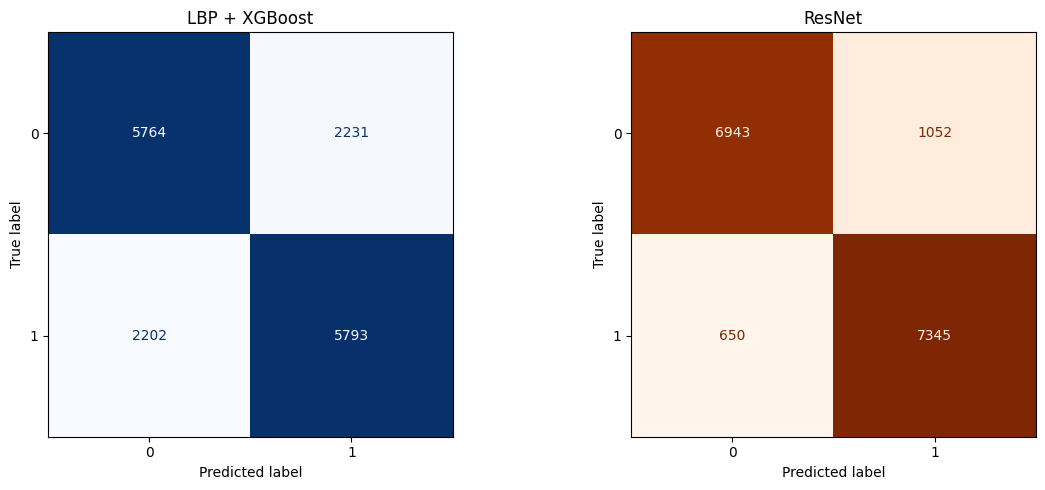

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrices
cm_lbp = confusion_matrix(y_test, y_pred)
cm_resnet = confusion_matrix(all_labels, all_preds)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# LBP + XGBoost
disp_lbp = ConfusionMatrixDisplay(confusion_matrix=cm_lbp)
disp_lbp.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title("LBP + XGBoost")

# ResNet
disp_resnet = ConfusionMatrixDisplay(confusion_matrix=cm_resnet)
disp_resnet.plot(ax=axes[1], cmap='Oranges', colorbar=False)
axes[1].set_title("ResNet")

plt.tight_layout()
plt.show()


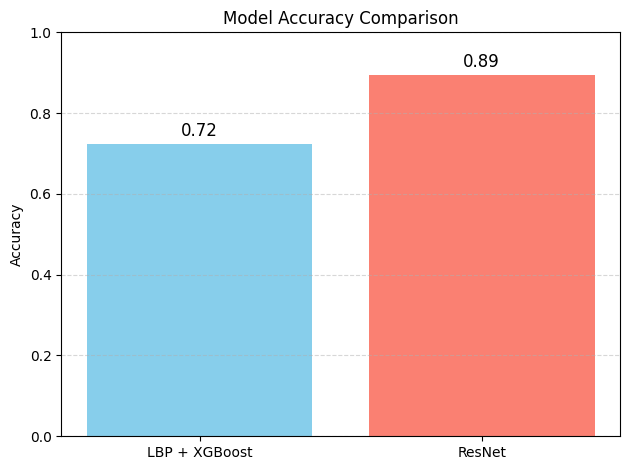

In [31]:
from sklearn.metrics import accuracy_score

acc_lbp = accuracy_score(y_test, y_pred)
acc_resnet = accuracy_score(all_labels, all_preds)

plt.bar(['LBP + XGBoost', 'ResNet'], [acc_lbp, acc_resnet], color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.grid(axis='y', linestyle='--', alpha=0.5)
for i, acc in enumerate([acc_lbp, acc_resnet]):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()


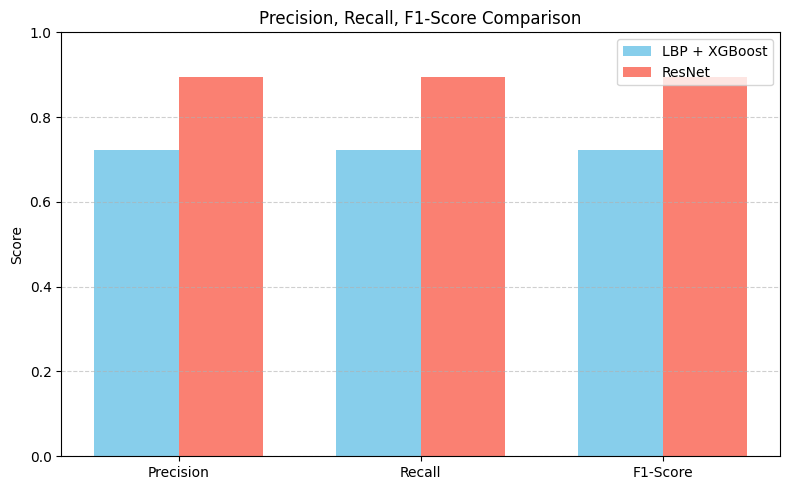

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Macro-averaged scores (or use 'weighted' if classes are imbalanced)
precision_lbp = precision_score(y_test, y_pred, average='macro')
recall_lbp = recall_score(y_test, y_pred, average='macro')
f1_lbp = f1_score(y_test, y_pred, average='macro')

precision_resnet = precision_score(all_labels, all_preds, average='macro')
recall_resnet = recall_score(all_labels, all_preds, average='macro')
f1_resnet = f1_score(all_labels, all_preds, average='macro')

# Data for plotting
metrics = ['Precision', 'Recall', 'F1-Score']
lbp_scores = [precision_lbp, recall_lbp, f1_lbp]
resnet_scores = [precision_resnet, recall_resnet, f1_resnet]

x = range(len(metrics))

# Plot
plt.figure(figsize=(8, 5))
bar_width = 0.35

plt.bar([i - bar_width/2 for i in x], lbp_scores, width=bar_width, label='LBP + XGBoost', color='skyblue')
plt.bar([i + bar_width/2 for i in x], resnet_scores, width=bar_width, label='ResNet', color='salmon')

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Precision, Recall, F1-Score Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
